<a href="https://colab.research.google.com/github/apoorvyadav1111/Machine-Learning-Practice/blob/master/Airplane_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Practice from this origin tutorial: https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

In [ ]:
%tensorflow_version 1.14
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import keras
%matplotlib inline

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
import os

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
def get_iou(bb1,bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    x_left = max(bb1['x1'],bb2['x1'])
    y_top = max(bb1['y1'],bb2['y1'])
    x_right = min(bb1['x2'],bb2['x2'])
    y_bottom = min(bb1['y2'],bb2['y2'])
    
    if x_right<x_left or y_bottom<y_top:
        return 0.0
    
    intersection_area = (x_right - x_left)*(y_bottom - y_top)
    
    bb1_area = (bb1['x2']-bb1['x1'])*(bb1['y2']-bb1['y1'])
    bb2_area = (bb2['x2']-bb2['x1'])*(bb2['y2']-bb2['y1'])
    
    union_area = bb1_area+bb2_area - intersection_area
    
    iou = intersection_area/float(union_area)
    
    assert iou>=0.0
    assert iou<=1.0
    
    return iou                                   

In [1]:
path = ""
annot = ""

In [ ]:
train_images=[]
train_labels=[]
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 5:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                                #cv2.rectangle(imout,(x,y),(x+w,y+h),(0,255,0),4,cv2.LINE_AA)
                        else :
                            fflag =1
                        if falsecounter <4:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                                #cv2.rectangle(imout,(x,y),(x+w,y+h),(0,255,0),4,cv2.LINE_AA)

                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [ ]:
X_new_less = np.array(train_images)
y_new_less = np.array(train_labels)

In [ ]:
np.save("",X_new_less)
np.save("",y_new_less)

In [ ]:
X_new = np.load("")
y_new = np.load("")

In [ ]:
X_new = X_new_less
y_new = y_new_less

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet',include_top=True)





553467904/553467096 [==============================] - 12s 0us/step








In [ ]:
for layers in vggmodel.layers[:15]:
    print(layers)
    layers.trainable = False
x = vggmodel.layers[-2].output
predictions = Dense(2,activation="softmax")(x)
model_final = Model(input=vggmodel.input,output=predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy,
                   optimizer=opt,
                   metrics=["accuracy"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class Mylabelbinarizer(LabelBinarizer):
    def transform(self,y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y,1-Y))
        else:
            return Y
        
    def inverse_transform(self,Y,threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:,0],threshold)
        else:
            return super().inverse_transform(Y,threshold)
lenc = Mylabelbinarizer()
Y = lenc.fit_transform(y_new)

X_train, X_test, y_train,y_test = train_test_split(X_new,Y,test_size=0.7)

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           rotation_range=90)
traindata = trdata.flow(x=X_train,y=y_train)

tsdata = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           rotation_range=90)
testdata = tsdata.flow(x=X_test,y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

ckpt = ModelCheckpoint("model_rcnn.h5",monitor='val_loss',
                       verbose=1,
                       save_best_only=True,
                       save_weights_only=False,
                       mode='auto',
                       period=1)

early = EarlyStopping(monitor='val_loss',
                      verbose=1,
                      min_delta=0,
                      patience=10,
                      mode='auto')

hist = model_final.fit_generator(generator=traindata,
                                 steps_per_epoch=10,
                                 epochs=1000,
                                 validation_data=testdata,
                                 validation_steps=2,
                                 callbacks=[ckpt,early])


Epoch 1/1000
ERROR! Session/line number was not unique in database. History logging moved to new session 60
10/10 [==============================] - 5s 501ms/step - loss: 0.3466 - acc: 0.9406 - val_loss: 0.0539 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.05393, saving model to model_rcnn.h5
Epoch 2/1000
10/10 [==============================] - 3s 312ms/step - loss: 0.2425 - acc: 0.9219 - val_loss: 0.1142 - val_acc: 0.9531

Epoch 00002: val_loss did not improve from 0.05393
Epoch 3/1000
10/10 [==============================] - 3s 294ms/step - loss: 0.2687 - acc: 0.9004 - val_loss: 0.1552 - val_acc: 0.9688

Epoch 00003: val_loss did not improve from 0.05393
Epoch 4/1000
10/10 [==============================] - 3s 312ms/step - loss: 0.1908 - acc: 0.9469 - val_loss: 0.1348 - val_acc: 0.9375

Epoch 00004: val_loss did not improve from 0.05393
Epoch 5/1000
10/10 [==============================] - 3s 315ms/step - loss: 0.2561 - acc: 0.9281 - val_loss: 0.1785 - val_acc: 0.9

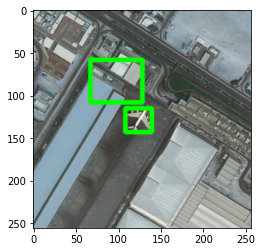

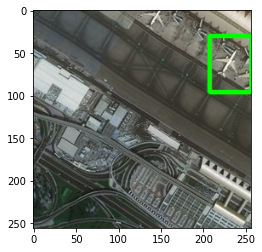

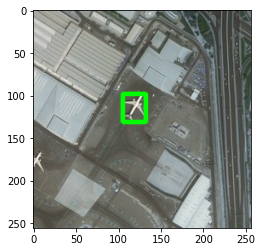

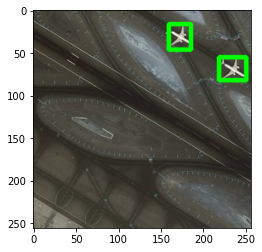

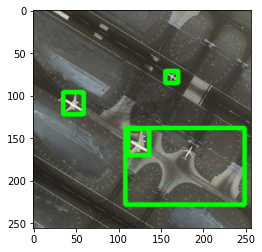

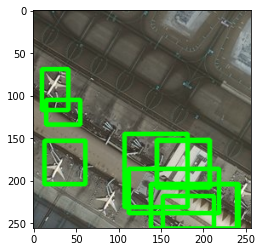

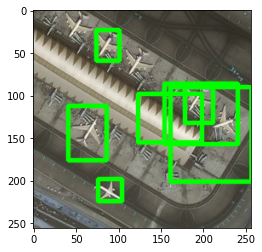

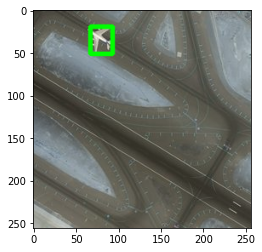

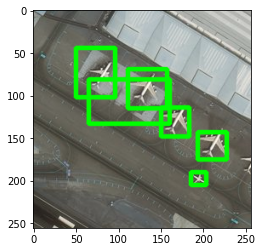

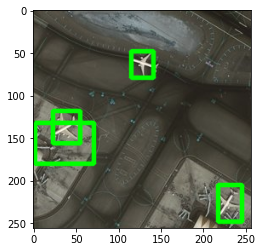

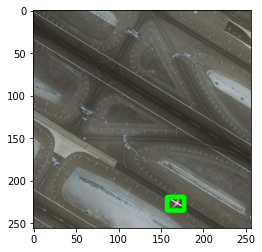

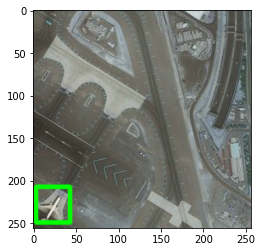

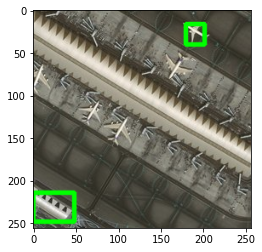

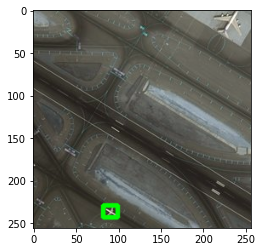

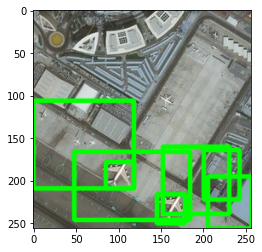

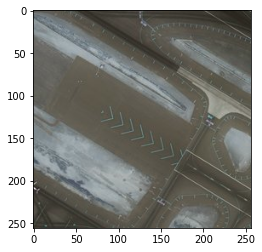

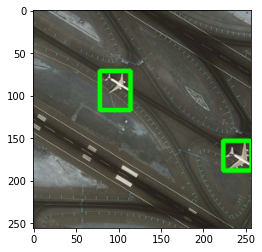

In [ ]:
path = ""
z = 0
for e,i in enumerate(os.listdir(path)):
  if i.startswith("4"):
    z+=1
    img = cv2.imread(os.path.join(path,i))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    for e,result in enumerate(ssresults):
      if e<2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        img = np.expand_dims(resized,axis=0)
        out = model_final.predict(img)
        if out[0][0] > 0.70:
          cv2.rectangle(imout,(x,y),(x+w,y+h),(0,255,0),4,cv2.LINE_AA)
    plt.figure()
    plt.imshow(imout)